In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'text-for-summarization:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4967965%2F8359571%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240922%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240922T222351Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0688357573b5b724a5b3fe658dbf8e30dfac666f7790aa2b3a132b41a30619c1693b784e901cefac76213004707566c92d40fc82ea7d873f250bcb2c9f2aef9dbad85c19cc2596aa6bee47360b1c62aef1cb5c487ee808007c4ea5ee3ff0cf1742a7f6c7ffbf70f89476b8d2a0437a32b19dd7331d833d43acdf7ddfaf2b8122601c4ac8dae140d0efd50f47dfae25326b402805c4055627c0754c11152a6257f5fea67754dfe736429859ffd91616a9e7ad7d8319ac1fde59b2c94192af22fbf85f8554d44eb643935cd63ead72caa66fb2e0764814d52378d9646e872cc086c311ab7ef04b35c77dcc7ed66c8bc70e0f230d3a0a6ac228b26764fbc0509f20'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1810 bytes downloaded
Downloaded and uncompressed: text-for-summarization
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os
import nltk
import re
import math
import operator
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag                   # ---------> POS tagging
from nltk.corpus import stopwords , state_union
from nltk.tokenize import PunktSentenceTokenizer
import spacy
from spacy import displacy                 # ---------> for Visualization
from string import punctuation
from string import punctuation
from IPython.display import HTML
from scipy.stats import norm
# ---------> for highlighting words
# Downloading Files
#nltk.download('stopwords')
#nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nlp = spacy.load('en_core_web_sm')
wordlemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
nltk.download('stopwords')
nltk.download('punkt')
Stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [16]:
text = """Germany, officially the Federal Republic of Germany (German: Bundesrepublik Deutschland), is a country in Central Europe. It is the most populous country in the European Union and the fourth-largest economy in the world by nominal GDP. Germany is bordered by Denmark to the north, Poland and the Czech Republic to the east, Austria to the southeast, and Switzerland to the south. To the west, it shares borders with France, Luxembourg, Belgium, and the Netherlands, while the Baltic Sea lies to the northeast and the North Sea to the northwest. The country has a rich history dating back to ancient times, with Germanic tribes being documented as early as the first century BCE.

The Holy Roman Empire, established in 800 CE, played a significant role in shaping medieval Europe, but the Thirty Years' War (1618–1648) left the region fragmented. In the 19th century, the German states began to unify, culminating in the formation of the German Empire in 1871 under the leadership of Prussia. Germany rapidly industrialized and became a major world power.
Following its defeat in World War I, Germany was left economically and politically destabilized, leading to the rise of the Nazi regime. Adolf Hitler's leadership during World War II resulted in widespread destruction, the Holocaust, and the eventual division of Germany into West and East Germany during the Cold War. In 1990, following the fall of the Berlin Wall and the collapse of the Soviet Union, Germany was reunified as a single country.

Today, Germany is known for its influential role in the European Union and its leadership in technological innovation, environmental policy, and economic stability. The country is a key player in global affairs, promoting democracy, human rights, and multilateral cooperation across various international organizations. Germany's diverse culture, heritage, and contributions to philosophy, science, and the arts continue to shape its identity on the world stage""".replace('\n',' ')

In [17]:
words = word_tokenize(text)
vis = words
words[:10]

['Germany',
 ',',
 'officially',
 'the',
 'Federal',
 'Republic',
 'of',
 'Germany',
 '(',
 'German']

In [18]:
i = 1
sentences = sent_tokenize(text)
for sen in sentences:
  if i <= 5:
    i = i+1
    print(sen,'\n')
    print('--'*65)







Germany, officially the Federal Republic of Germany (German: Bundesrepublik Deutschland), is a country in Central Europe. 

----------------------------------------------------------------------------------------------------------------------------------
It is the most populous country in the European Union and the fourth-largest economy in the world by nominal GDP. 

----------------------------------------------------------------------------------------------------------------------------------
Germany is bordered by Denmark to the north, Poland and the Czech Republic to the east, Austria to the southeast, and Switzerland to the south. 

----------------------------------------------------------------------------------------------------------------------------------
To the west, it shares borders with France, Luxembourg, Belgium, and the Netherlands, while the Baltic Sea lies to the northeast and the North Sea to the northwest. 

------------------------------------------------------

Lowering All words

In [8]:
def lowercasing(word):
  word =word.lower()
for word in words:
  lowercasing(word)
vis = words
print(words[:10])

['India', ',', 'officially', 'the', 'Republic', 'of', 'India', '(', 'Hindi', ':']


In [10]:
contraction_mapping = {
    "ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not","didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not","he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am", "I've": "I have", "i'd": "i would","i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would","it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam","mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock","oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have","she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
    "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as","this's": "this is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would","there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would", "they'd've": "they would have","they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have","wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are","we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is","where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have","why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have","would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
    "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
    "you're": "you are", "you've": "you have"
}

def preprocess_text(words):
  for contraction,expanded in contraction_mapping.items():
    words = words.replace(contraction,expanded)

for word in words:
  preprocess_text(word)
vis = words



Tokinization the text

In [13]:
stopwords = list(stopwords.words("english"))+list(punctuation)+list([0,1,2,3,4,5,6,7,8,9])
stopwords[-1]

9

In [19]:
without_stop = []
def stopwords_removal(words):
  if word not in stopwords:
    without_stop.append(word)
for word in words:
  stopwords_removal(word)
words = without_stop
vis = words
print(len(vis))
vis2= list(set(vis))
print(vis)


194
['Germany', 'officially', 'Federal', 'Republic', 'Germany', 'German', 'Bundesrepublik', 'Deutschland', 'country', 'Central', 'Europe', 'It', 'populous', 'country', 'European', 'Union', 'fourth-largest', 'economy', 'world', 'nominal', 'GDP', 'Germany', 'bordered', 'Denmark', 'north', 'Poland', 'Czech', 'Republic', 'east', 'Austria', 'southeast', 'Switzerland', 'south', 'To', 'west', 'shares', 'borders', 'France', 'Luxembourg', 'Belgium', 'Netherlands', 'Baltic', 'Sea', 'lies', 'northeast', 'North', 'Sea', 'northwest', 'The', 'country', 'rich', 'history', 'dating', 'back', 'ancient', 'times', 'Germanic', 'tribes', 'documented', 'early', 'first', 'century', 'BCE', 'The', 'Holy', 'Roman', 'Empire', 'established', '800', 'CE', 'played', 'significant', 'role', 'shaping', 'medieval', 'Europe', 'Thirty', 'Years', 'War', '1618–1648', 'left', 'region', 'fragmented', 'In', '19th', 'century', 'German', 'states', 'began', 'unify', 'culminating', 'formation', 'German', 'Empire', '1871', 'leaders

In [20]:
stemmed_words = []
for word in words:
    stemmed = stemmer.stem(word)
    stemmed_words.append(stemmed)
words = stemmed_words
words[:10]

['germani',
 'offici',
 'feder',
 'republ',
 'germani',
 'german',
 'bundesrepublik',
 'deutschland',
 'countri',
 'central']

In [21]:
lemmatized_words = []
for word in words:
    lemmatized_words.append(wordlemmatizer.lemmatize(word))
words = lemmatized_words
words[:10]

['germani',
 'offici',
 'feder',
 'republ',
 'germani',
 'german',
 'bundesrepublik',
 'deutschland',
 'countri',
 'central']

In [23]:
for i in sentences[ : 1]:
    for w, t in pos_tag(words) :
        print (f'Word :( {w :{7}} )    Type : (   {t :{5}} )    means : {spacy.explain(t)}')
        print('...................................................................................................')

    print("\n########################################################################################################\n")


Word :( germani )    Type : (   NN    )    means : noun, singular or mass
...................................................................................................
Word :( offici  )    Type : (   MD    )    means : verb, modal auxiliary
...................................................................................................
Word :( feder   )    Type : (   VB    )    means : verb, base form
...................................................................................................
Word :( republ  )    Type : (   NN    )    means : noun, singular or mass
...................................................................................................
Word :( germani )    Type : (   JJ    )    means : adjective (English), other noun-modifier (Chinese)
...................................................................................................
Word :( german  )    Type : (   JJ    )    means : adjective (English), other noun-modifier (Chinese)
........

In [24]:
# Extract the first 5 sentences from the sentences list
SUMMARY = nlp(' '.join(words[:10]))
#Render the named entities visualization
displacy.render(SUMMARY, style='ent', jupyter=True, options={'distance': 90})

In [25]:
# Extract the first 5 sentences from the sentences list
SUMMARY = nlp(' '.join(words[:10]))
#Render the named entities visualization
displacy.render(SUMMARY, style='dep', jupyter=True, options={'distance': 90})

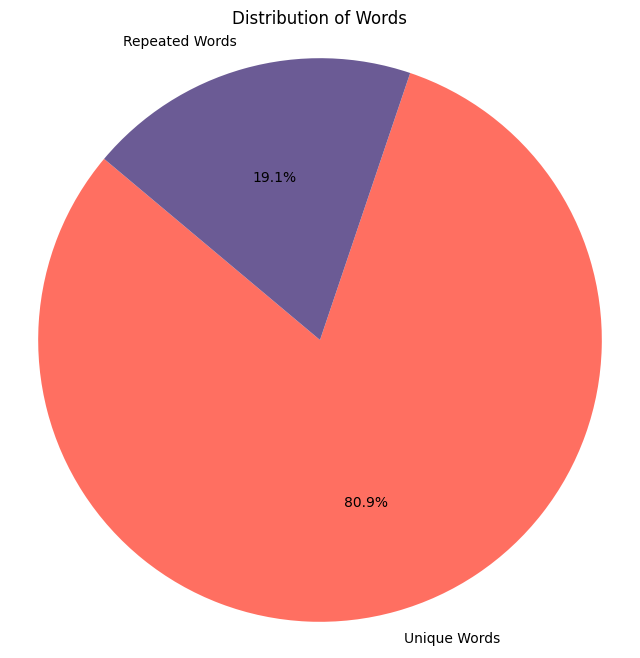

The number of words in text is: 194 and Vocabulary size is: 157


In [28]:
num_words = len(vis)

num_unique_words = len(set(vis2))
labels = ['Unique Words', 'Repeated Words']
sizes = [num_unique_words, num_words - num_unique_words]

colors = ['#FF6F61', '#6B5B95']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Distribution of Words')
plt.show()

print(f'The number of words in text is: {num_words} and Vocabulary size is: {num_unique_words}')
